# Telco Customer Churn Prediction with PySpark

## [1] Spark Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, count, isnan
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
spark = SparkSession.builder \
    .appName("ThaiTel Customer Churn") \
    .getOrCreate()

## [2] Load Data

In [3]:
df = spark.read.parquet("/home/jovyan/code/data/dataset_v7.snappy.parquet")

In [4]:
# Quick look at schema
df.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- location: string (nullable = true)
 |-- contract_type: string (nullable = true)
 |-- service_bundle: string (nullable = true)
 |-- customer_tenure: integer (nullable = true)
 |-- tier: string (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- internet_type: string (nullable = true)
 |-- complaint_call_count: integer (nullable = true)
 |-- sms_in: integer (nullable = true)
 |-- arpu: float (nullable = true)
 |-- churn: integer (nullable = true)
 |-- daily_calls_1: float (nullable = true)
 |-- daily_call_duration_1: float (nullable = true)
 |-- daily_data_usage_1: float (nullable = true)
 |-- daily_texts_1: float (nullable = true)
 |-- peak_hour_usage_1: float (nullable = true)
 |-- daily_calls_2: float (nullable = true)
 |-- daily_call_duration_2: float (nullable = true)
 |-- daily_data_usage_2: float (nullable = true)
 |-- daily_texts_2: float

## [3] Data Preprocessing

In [5]:
# Handle missing values (fill numeric with 0, categorical with 'unknown')
categorical_cols = ['gender', 'location', 'contract_type', 'service_bundle',
                    'tier', 'customer_type', 'internet_type']

for col_name in categorical_cols:
    df = df.fillna({col_name: 'unknown'})

df = df.fillna(0)  # For numerical columns

In [6]:
df.show(5)

+-----------+---+------+--------+-------------+--------------+---------------+------+-------------+-------------+--------------------+------+-----+-----+-------------+---------------------+------------------+-------------+-----------------+-------------+---------------------+------------------+-------------+-----------------+-------------+---------------------+------------------+-------------+-----------------+-------------+---------------------+------------------+-------------+-----------------+-------------+---------------------+------------------+-------------+-----------------+-------------+---------------------+------------------+-------------+-----------------+-------------+---------------------+------------------+-------------+-----------------+-------------+---------------------+------------------+-------------+-----------------+-------------+---------------------+------------------+-------------+-----------------+--------------+----------------------+-------------------+------

In [7]:
from functools import reduce
from pyspark.sql.functions import col

agg_exprs = []
usage_fields = ['daily_calls', 'daily_call_duration', 'daily_data_usage', 'daily_texts', 'peak_hour_usage']

# Aggregate usage patterns (calls, duration, data, texts)
for field in usage_fields:
    # Create list of columns: daily_calls_1 to daily_calls_30 (example)
    cols = [col(f"{field}_{i}") for i in range(1, 31)]
    # Sum them using reduce
    summed_col = reduce(lambda a, b: a + b, cols)
    agg_exprs.append(summed_col.alias(f"{field}_total"))
    

In [8]:
df_agg = df.select(
    'customer_id', 'age', 'gender', 'location', 'contract_type', 'service_bundle',
    'customer_tenure', 'tier', 'customer_type', 'internet_type', 'complaint_call_count',
    'sms_in', 'arpu', 'churn', *agg_exprs
)

# Encode categorical variables
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx", handleInvalid="keep") for col in categorical_cols]

# Assemble features
feature_cols = ['age', 'customer_tenure', 'complaint_call_count', 'sms_in', 'arpu',
                'daily_calls_total', 'daily_call_duration_total', 'daily_data_usage_total',
                'daily_texts_total', 'peak_hour_usage_total'] + [c+"_idx" for c in categorical_cols]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

## [4] Modeling

In [9]:
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn", seed=42)

pipeline = Pipeline(stages=indexers + [assembler, scaler, rf])

# Hyperparameter Tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.numTrees, [50, 100]) \
    .build()

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=BinaryClassificationEvaluator(labelCol="churn"),
                    numFolds=3)

# Fit model
model = cv.fit(df_agg)

## [5] Evaluate

In [10]:
predictions = model.transform(df_agg)
evaluator = BinaryClassificationEvaluator(labelCol="churn")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc:.4f}")

AUC: 0.9495


In [11]:
# Feature Importances (optional, if needed for business insights)
rf_model = model.bestModel.stages[-1]
importances = rf_model.featureImportances

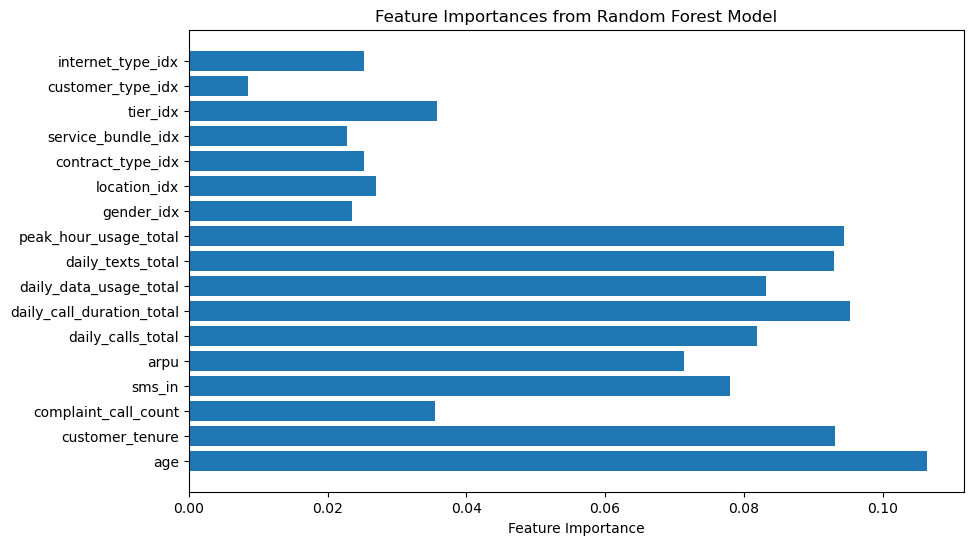

In [12]:
# plot feature importances
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_cols)
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest Model')
plt.show()